In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import os
import collections
from collections import Counter

# Dataset exploration and understanding

## 1. Dataset Statistics

In [6]:
folder_path = '../image_chips_native'

tif_count = sum(1 for file in os.listdir(folder_path))

print(f"Number of images present : {tif_count}")

Number of images present : 2553


In [7]:
labels_path = "../labels/labels_native" 
images_path = "../image_chips_native"

image_files = {os.path.splitext(f)[0] for f in os.listdir(images_path)}

label_counts = collections.defaultdict(int)

total_solar_panels = 0  

for label_file in os.listdir(labels_path):
    if label_file.endswith(".txt"):
        image_name = os.path.splitext(label_file)[0]
        with open(os.path.join(labels_path, label_file), "r") as f:
            num_labels = sum(1 for _ in f)  
        label_counts[image_name] = num_labels  
        total_solar_panels += num_labels  

value_counts = collections.Counter(label_counts.values())

zero_label_count = len(image_files - set(label_counts.keys()))
if zero_label_count > 0:
    value_counts[0] = zero_label_count

total_images = 0
for count, num_images in sorted(value_counts.items()):
    print(f"{num_images} Images have {count} labels")
    total_images += num_images

print("\nTotal Images Scanned:", total_images)
print("Total Solar Panels Detected:", total_solar_panels)

11 Images have 0 labels
81 Images have 1 labels
167 Images have 2 labels
221 Images have 3 labels
218 Images have 4 labels
217 Images have 5 labels
189 Images have 6 labels
170 Images have 7 labels
184 Images have 8 labels
169 Images have 9 labels
121 Images have 10 labels
97 Images have 11 labels
84 Images have 12 labels
69 Images have 13 labels
49 Images have 14 labels
46 Images have 15 labels
41 Images have 16 labels
36 Images have 17 labels
25 Images have 18 labels
29 Images have 19 labels
14 Images have 20 labels
4 Images have 21 labels
1 Images have 22 labels
4 Images have 23 labels
2 Images have 24 labels
4 Images have 25 labels
3 Images have 26 labels
5 Images have 27 labels
5 Images have 28 labels
15 Images have 29 labels
20 Images have 30 labels
8 Images have 31 labels
7 Images have 32 labels
13 Images have 33 labels
19 Images have 34 labels
10 Images have 35 labels
6 Images have 36 labels
17 Images have 37 labels
13 Images have 38 labels
6 Images have 39 labels
9 Images have

In [12]:
labels_dir = "../labels/labels_native"
category_counts = Counter()

for file in os.listdir(labels_dir):
    if file.endswith(".txt"):
        with open(os.path.join(labels_dir, file), "r") as f:
            for line in f:
                parts = line.strip().split()
                category = parts[0]
                category_counts[category] += 1

for category, count in category_counts.items():
    print(f"Category {category}: {count} objects")

Category 0: 29267 objects
Category 2: 228 objects
Category 1: 130 objects


In [18]:
29267+228+130

29625

## 2. Statistics of the area of solar panels in meters 

In [ ]:
# Sample solar panel label --> 0 0 0.8725961538461539 0.7007211538461539 0.057692307692307696 0.05528846153846154
# It indicates category, x-center, y-center, x-width, y-height (of the bounding box scaled).

# For values of these in pixels we have to multiply them with image res (416x416 here)
# So here, 0, 0.872596 × 416, 0.700721 × 416, 0.057692 × 416, 0.055288 × 416   which becomes  (0, 364, 291, 24,  23)
# So, the bounding box in pixel coordinates is: Center: (364,291), Width: 24, Height: 23

# To convert them in meters from pixels, we have to use info provided in README
# Lets say image belongs to Tile 1, then Tile 1: (307670.04, 0.31, 0.0, 5434427.100000001, 0.0, -0.31) is its geotransform
# Geotransform --> (X-origin, X_scale (Each pixel width in m), X_skew, y_origin, y_skew, y_scale)

# So the label in meters will be 
# Center at ((307670.04 + (364 × 0.31)), (5434427.10+(291×−0.31))) = (307782.88, 5434336.89) geographically
# Width --> 24 × 0.31 = 7.44 meters, Height --> |23×(−0.31)| = 7.13 meters
# And thus, the area of sample solar panel = Width x Height = 7.44 × 7.13 = 53.06 square meters

In [32]:
labels_dir = "../labels/labels_native"

areas = []

for file in tqdm(os.listdir(labels_dir)):
    image_size = 416
    meters_per_pixel = 0.31
    
    with open(os.path.join(labels_dir, file), "r") as f:
        for line in f:
            parts = line.strip().split()
            _, _, _, x_width, y_width = map(float, parts)
            area = (x_width * image_size) * (y_width * image_size) * (meters_per_pixel ** 2)
            areas.append(area)

mean = np.mean(areas)
std = np.std(areas)
median = np.median(areas)
print(f"Mean area: {mean:.2f} square meters")
print(f"Median area: {median:.2f} square meters")
print(f"Standard Deviation: {std:.2f} square meters")

100%|██████████| 2542/2542 [00:00<00:00, 12467.11it/s]

Mean area: 191.52 square meters
Median area: 91.68 square meters
Standard Deviation: 630.70 square meters


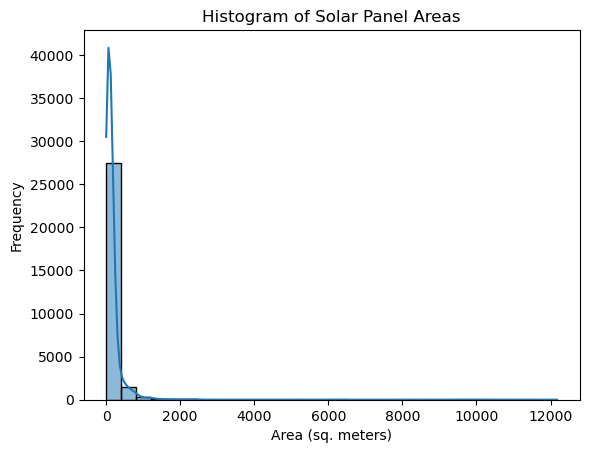

In [33]:
sns.histplot(areas, bins=30, kde=True)
plt.xlabel("Area (sq. meters)")
plt.ylabel("Frequency")
plt.title("Histogram of Solar Panel Areas")
plt.show()

In [34]:
# Inferences : 
# 1. The mean area is 191.52 sq m. and median is 91.68 sq m.
# 2. The distribution is heavily right skewed, showing that most of the solar panels have area lower values.
# 3. There are very few extremely high area values which create long tail extending upto 12000 sq m.

# Conclusion - The data have far more areas of lower values than the higher ones.